# Trabalho 4 - Redes Neurais
Desenvolver um experimento completo usando LSTMs para uma aplicação sequencial. Exemplos de aplicações: classificação de vídeo, tradução, ...

## Imports
Primeiro é preciso importar as bibliotecas e funções a serem utilizadas.

In [2]:
import math
import torch
import torch.utils.data as data_utils
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler 

## Parâmetros

In [3]:
sequence_length = 60
input_size = 1
hidden_size = 25
output_size = 1
learning_rate = 0.001
batch_size = 1
n_epoch = 50

## Pegando os datasets
Utilizando a biblioteca yfinance para pegar os dados sobre as ações de uma empresa. No caso desse experimento estarei utilizando a PETR4. O objetivo é criar um modelo que use os 60 dias anteriores para prever o próximo.

In [4]:
stock_data = yf.download('PETR4.SA', start='2010-01-01', end='2023-06-13')
stock_data = stock_data.dropna()
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,36.950001,37.320000,36.820000,37.320000,11.541964,13303600
2010-01-05,37.380001,37.430000,36.799999,37.000000,11.442999,21396400
2010-01-06,36.799999,37.500000,36.799999,37.500000,11.597634,18720600
2010-01-07,37.270000,37.450001,37.070000,37.150002,11.489392,10964600
2010-01-08,37.160000,37.389999,36.860001,36.950001,11.427537,14624200


In [5]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,36.950001,37.320000,36.820000,37.320000,11.541964,13303600
2010-01-05,37.380001,37.430000,36.799999,37.000000,11.442999,21396400
2010-01-06,36.799999,37.500000,36.799999,37.500000,11.597634,18720600
2010-01-07,37.270000,37.450001,37.070000,37.150002,11.489392,10964600
2010-01-08,37.160000,37.389999,36.860001,36.950001,11.427537,14624200
...,...,...,...,...,...,...
2023-06-05,27.540001,27.559999,27.230000,27.469999,25.781700,39321700
2023-06-06,27.450001,28.250000,27.209999,28.049999,26.326052,75426600
2023-06-07,28.650000,29.059999,28.430000,28.870001,27.095657,82330400


Text(0, 0.5, 'Prices (R$)')

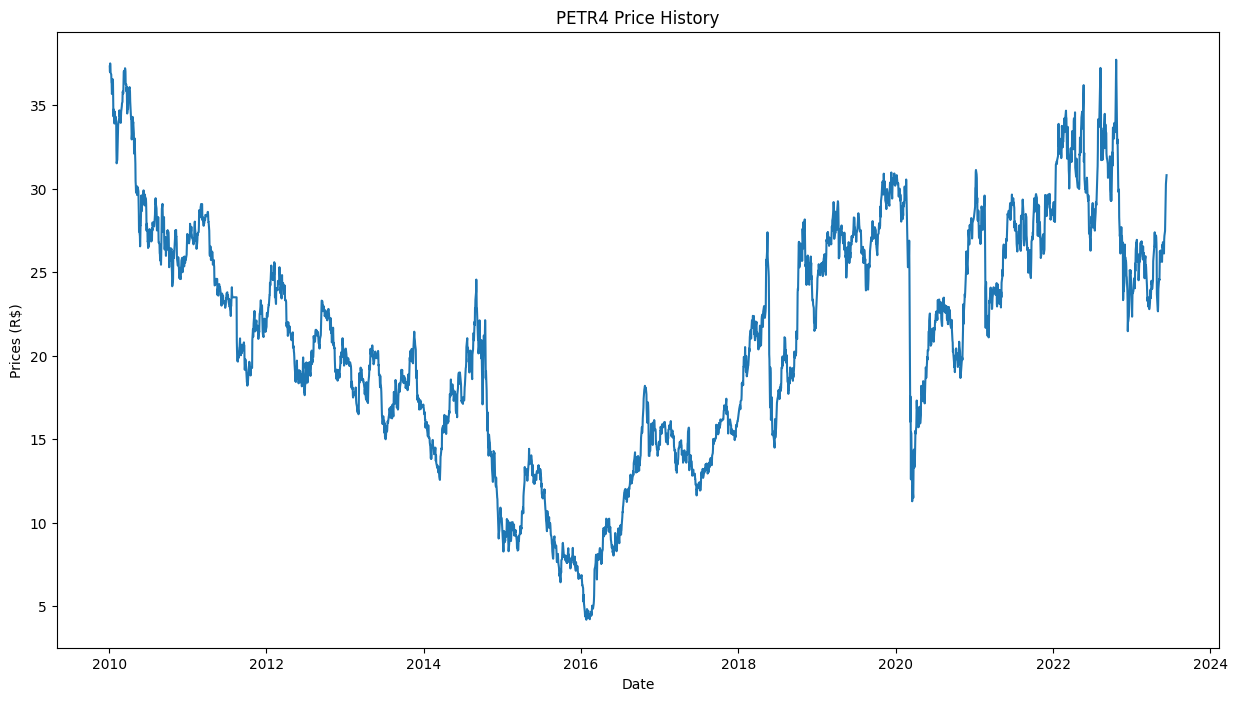

In [6]:
plt.figure(figsize=(15, 8))
plt.title('PETR4 Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices (R$)')

### Criando o dataset de treino

In [7]:
# Pegando apenas os valores de fechamento
close_prices = stock_data['Close']
values = close_prices.values

# Pegando o tamanho do conjunto de treinamento
training_data_len = math.ceil(len(values)* 0.8)

# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# Pegando os primeiros 80% dos dados para treinamento
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

# Separando os dados de treino na sequência de 60 dias
for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])
    
# Convertendo os dados para numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape dos dados para 3 dimensões
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Criando o dataset de teste

In [8]:
# Pegando os 20% finais dos dados para teste
test_data = scaled_data[training_data_len-sequence_length: , : ]

x_test = []
y_test = values[training_data_len:]

# Separando os dados de teste na sequência de 60 dias
for i in range(sequence_length, len(test_data)):
  x_test.append(test_data[i-sequence_length:i, 0])

# Convertendo os dados para numpy arrays
x_test = np.array(x_test)

# Reshape dos dados para 3 dimensões
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Separando em Treino e Validação

In [9]:
x_train_t, x_valid, y_train_t, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
print("Shape do treino: ", x_train.shape)
print("Shape do teste: ", x_test.shape)
print("Shape da validação: ", x_valid.shape)

Shape do treino:  (2608, 60, 1)
Shape do teste:  (667, 60, 1)
Shape da validação:  (522, 60, 1)


In [10]:
# Criando os dataloaders
train = torch.tensor(x_train_t.astype(np.float32))
train_target = torch.tensor(y_train_t.astype(np.float32))
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

valid = torch.tensor(x_valid.astype(np.float32))
valid_target = torch.tensor(y_valid.astype(np.float32))
valid_tensor = data_utils.TensorDataset(valid, valid_target) 
valid_loader = data_utils.DataLoader(dataset = valid_tensor, batch_size = batch_size, shuffle = True)

## Definindo o device
Como minha placa de vídeo é AMD não possuo Cuda.

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Definindo a Rede Neural
Criei uma classe que herda nn.Module e defini as camadas da rede aqui. Primeiro passa em uma camada de LSTM com o hidden_size de 25, ou seja, o output dela vai ser um vetor de tamanho 25. Depois passa em uma camada linear que recebe os 25 valores e retorna apenas 1 que é o output final da rede.

In [12]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_len, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.lstm = nn.LSTM(input_len, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        out = self.output(lstm_out[:, -1, :])
        return out

### Jogando a Rede para a CPU

In [13]:
model = NeuralNetwork(input_size, hidden_size, output_size).to(device)
print(model)

NeuralNetwork(
  (lstm): LSTM(1, 25, batch_first=True)
  (output): Linear(in_features=25, out_features=1, bias=True)
)


### Definindo a loss function e o otimizador

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Treinando e Validando a Rede
### Funções para implementar o treino e a validação
Realizam os ajustes de pesos das redes e calculam a perda e acurácia do algoritmo

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    loss_sum = 0
    i = 0
    for X, y in dataloader:
        X = X.reshape(-1, sequence_length, input_size)
        pred = model(X)

        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item() * len(X)
        
    avg_loss = loss_sum / size 
    print(f"Train Error: Avg loss = {avg_loss:>8f}")
    return avg_loss

In [16]:
def valid_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
      for X, y in dataloader:
          pred = model(X)
          loss += loss_fn(pred, y).item() * len(X)

    avg_loss = loss / size
    print(f"Valid Error: Avg loss = {avg_loss:>8f}")
    
    return avg_loss

### Loop do Treino
Utilizei 50 epochs pois o desempenho não melhorava muito depois disso. Salvei o modelo com melhor desempenho de perda na validação.

In [17]:
loss_valid_history = []
loss_train_history = []
min_loss_valid = np.Inf


for epoch in range(n_epoch):
    print(f"Epoch {epoch+1}\n-----------------------------------")
    loss_train = train_loop(train_loader, model, loss_fn, optimizer)
    loss_valid = valid_loop(valid_loader, model, loss_fn)
    if  loss_valid <= min_loss_valid:
        print(f"Validation loss decreased ({min_loss_valid:>0.6f} --> {loss_valid:>0.6f}).  Saving model ...")
        min_loss_valid = loss_valid
        torch.save(model.state_dict(), 'models/best_model_trab4.pt')
    print("-----------------------------------\n")


    loss_train_history.append(loss_train)
    loss_valid_history.append(loss_valid)

Epoch 1
-----------------------------------
Train Error: Avg loss = 0.003257
Valid Error: Avg loss = 0.002348
Validation loss decreased (inf --> 0.002348).  Saving model ...
-----------------------------------

Epoch 2
-----------------------------------
Train Error: Avg loss = 0.000616
Valid Error: Avg loss = 0.000933
Validation loss decreased (0.002348 --> 0.000933).  Saving model ...
-----------------------------------

Epoch 3
-----------------------------------
Train Error: Avg loss = 0.000451
Valid Error: Avg loss = 0.000687
Validation loss decreased (0.000933 --> 0.000687).  Saving model ...
-----------------------------------

Epoch 4
-----------------------------------
Train Error: Avg loss = 0.000372
Valid Error: Avg loss = 0.000769
-----------------------------------

Epoch 5
-----------------------------------
Train Error: Avg loss = 0.000333
Valid Error: Avg loss = 0.000616
Validation loss decreased (0.000687 --> 0.000616).  Saving model ...
-------------------------------

### Desempenho no treino e na validação
Gráficos que mostram como foi a redução da loss function de acordo com as epócas de treino, tanto na validação quanto do próprio treino.

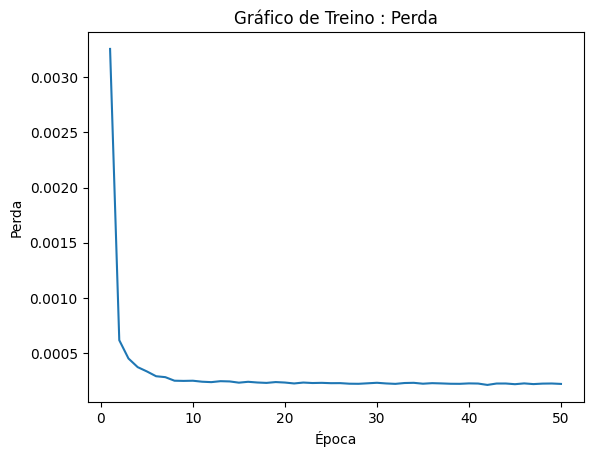

In [18]:
epoch_vec = list(range(1, n_epoch+1))

plt.title('Gráfico de Treino : Perda')
plt.plot(epoch_vec, loss_train_history, label='loss')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()

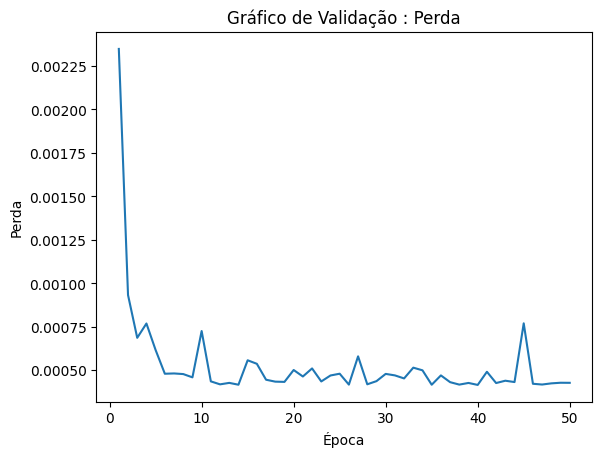

In [19]:
plt.title('Gráfico de Validação : Perda')
plt.plot(epoch_vec, loss_valid_history, label='loss')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()

## Testando o Modelo

### Pegando o Melhor modelo

In [20]:
model.load_state_dict(torch.load('models/best_model_trab4.pt'))

<All keys matched successfully>

### Pegando os Retornos da Rede

In [21]:
# Calculando as predições para o conjunto de teste
predictions_torch = model(torch.tensor(x_test.astype(np.float32)));

# Transformando as predições para o formato numpy
predictions_np = predictions_torch.detach().numpy()

# Invertendo a normalização
predictions = scaler.inverse_transform(predictions_np.reshape(-1,1))

## Resultados

Os resultados são mostrados a seguir, primeiro com a MSE-loss e depois com um gráfico que mostra a diferença da predição do meu modelo com o que é a realidade. É perceptível a semelhança no formato dos gráficos o que me deixou satisfeito com os resultados. Além disso, o valor de erro é baixo dado que a mética é "squared error".

Test Error: Avg loss = 1.114492


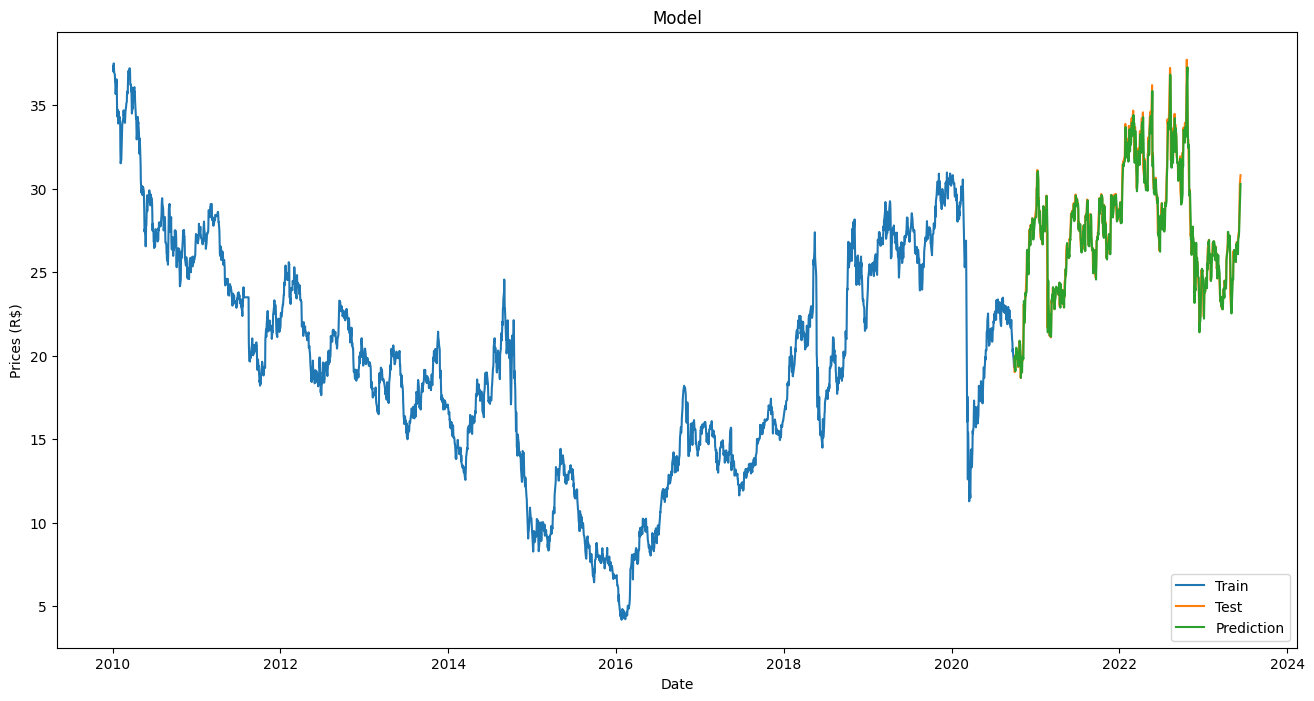

In [22]:
test_loss_avg = loss_fn(predictions_torch.reshape(-1), torch.tensor(y_test.astype(np.float32)))/len(predictions_torch)
print(f"Test Error: Avg loss = {test_loss_avg:>8f}")

data = stock_data.filter(['Close'])
train = data.iloc[:training_data_len]
validation = data.iloc[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Prices (R$)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Prediction'], loc='lower right')
plt.show()